# 第8章　ベイズ推定：データを元に「確信」を高める手法

## 8.2 ベイズ推定の回帰分析への応用

**[08BR-01]**

必要なモジュールをインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

from numpy.random import normal, multivariate_normal

**[08BR-02]**

正弦関数 $y=\sin(2\pi x)$ に、平均 0、標準偏差 0.3 の正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、$0\le x\le 1$ の区間を等分した `num` 個の点 $\{x_n\}_{n=1}^N$ に対して、対応する $\{t_n\}_{n=1}^N$ の値を生成します。

In [2]:
def create_dataset(num):
  xs = np.linspace(0, 1, num)
  ts = np.sin(2*np.pi*xs) + normal(loc=0, scale=0.3, size=num)
  return xs, ts

**[08BR-03]**

$N=4, 6, 10, 100$ の 4 種類のトレーニングセットを生成します。

In [3]:
trainset = []
for num in [4, 6, 10, 100]:
  xs, ts = create_dataset(num)
  trainset.append((xs, ts))

**[08BR-04]**

ベイズ推定の計算結果を返す関数を用意します。

これは、以下の値を返します。

* 点 $x$ の予測分布（正規分布）の平均 $m(x)$

$$
\displaystyle m(x) = \beta\boldsymbol\phi(x)^{\rm T}\mathbf S\sum_{n=1}^Nt_n\boldsymbol\phi(x_n) = \boldsymbol\phi(x)^{\rm T}\overline{\mathbf w}
$$

* 点 $x$ の予測分布（正規分布）の標準偏差 $s(x)$

$$
s(x) = \beta^{-1} + \boldsymbol\phi(x)^{\rm T}\mathbf S\boldsymbol\phi(x)
$$

* 係数 $w$ の事後分布（多次元正規分布）の平均ベクトル $\overline{\mathbf w}$

$$
\displaystyle \overline{\mathbf w} = \beta\mathbf S\sum_{n=1}^Nt_n\boldsymbol\phi(x_n)
$$

* 係数 $w$ の事後分布（多次元正規分布）の分散共分散行列 $\mathbf S$

$$
\displaystyle \mathbf S^{-1} = \alpha\mathbf I + \beta\sum_{n=1}^N\boldsymbol\phi(x_n)\boldsymbol\phi(x)^{\rm T}
$$

$\alpha^{-1}$ はパラメーター $\mathbf w$ の事前分布の分散、$\beta^{-1}$ は観測データの分散を表します。ここでは、次の値を使用します。

$$
\alpha^{-1} = 100^2,\ \beta^{-1} = 0.3^2
$$

In [4]:
def resolve(xs, ts, m):
  beta = 1.0/0.3**2   # 真の分布の分散
  alpha = 1.0/100**2  # 事前分布の分散

  def phi(x):
    return np.array([[x**k] for k in range(m+1)])

  # 分散共分散行列 S
  tmp = np.sum([np.dot(phi(x), phi(x).T) for x in xs], axis=0)
  s_inv = alpha * np.eye(m+1) + beta * tmp
  s = np.linalg.inv(s_inv)

  # 係数 w の平均
  tmp = np.sum([ts[n] * phi(xs[n]) for n in range(len(ts))], axis=0)
  w_mean = beta * np.dot(s, tmp)

  # 点 x の予測分布の平均 m(x)
  def mean_fun(xs): # universal function
    tmp = [np.dot(phi(x).T, w_mean)[0][0] for x in xs]
    return np.array(tmp)

  # 点 x の予測分布の標準偏差 √s(x)
  def deviation_fun(xs): # universal function
    tmp = [1.0/beta + np.dot(phi(x).T, np.dot(s, phi(x)))[0][0] for x in xs]
    return np.sqrt(np.array(tmp))

  return mean_fun, deviation_fun, w_mean, s

**[08BR-05]**

先ほどの関数を利用して、ベイズ推定の結果から予測されるデータ分布（次に観測されるデータの分布）をグラフ表示する関数を用意します。

In [5]:
def show_estimation(subplot, xs, ts, m):
  mean_fun, deviation_fun, _, _ = resolve(xs, ts, m)

  subplot.tick_params(axis='x', labelsize=12)
  subplot.tick_params(axis='y', labelsize=12)
  subplot.set_xlim(-0.05, 1.05)
  subplot.set_ylim(-2.0, 2.0)
  subplot.set_title('N={}'.format(len(ts)), fontsize=14)

  # トレーニングセットを表示
  subplot.scatter(xs, ts, marker='o', color='blue', label=None)

  # 真の曲線を表示
  linex = np.linspace(0, 1, 100)
  liney = np.sin(2*np.pi*linex)
  subplot.plot(linex, liney, color='green', linestyle='--')

  # 平均と標準偏差の曲線を表示
  m = mean_fun(linex)
  d = deviation_fun(linex)
  subplot.plot(linex, m, color='red', label='mean')
  subplot.plot(linex, m-d, color='black', linestyle='--')
  subplot.plot(linex, m+d, color='black', linestyle='--')
  subplot.legend(loc=1, fontsize=14)

**[08BR-06]**

予測分の平均 $m(x)$、および、標準偏差の幅を加えた値 $m(x)\pm \sqrt{s(x)}$ のグラフを描きます。

多項式の次数は $M=9$ を指定します。

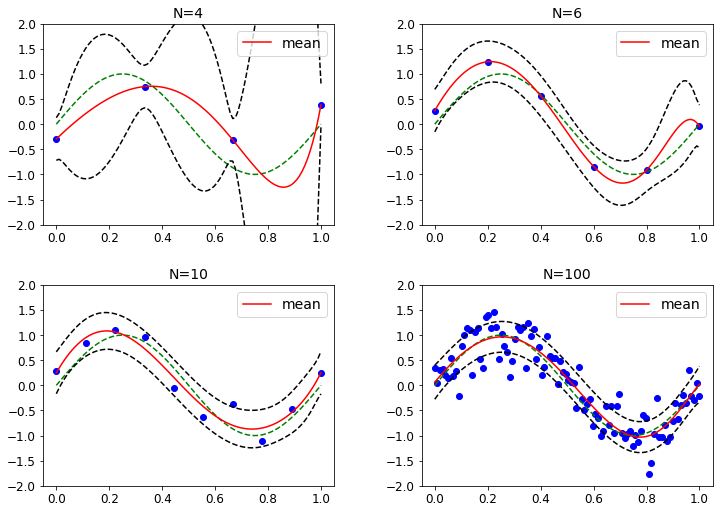

In [6]:
fig = plt.figure(figsize=(12, 8.5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, (xs, ts) in enumerate(trainset):
  subplot = fig.add_subplot(2, 2, i+1)
  show_estimation(subplot, xs, ts, 9)

**[08BR-07]**

事後分布に従って得られる係数のサンプルを取得して、多項式のサンプルを表示する関数を用意します。

この関数では、5種類のサンプルを取得してグラフを描きます。

In [7]:
def show_samples(subplot, xs, ts, m):
  mean_fun, _, w_mean, sigma = resolve(xs, ts, m)
  num = len(ts)
  ws_samples = multivariate_normal(w_mean.flatten(), sigma, 5)

  subplot.tick_params(axis='x', labelsize=12)
  subplot.tick_params(axis='y', labelsize=12)
  subplot.set_xlim(-0.05, 1.05)
  subplot.set_ylim(-2.0, 2.0)
  subplot.set_title('N={}'.format(len(ts)), fontsize=14)

  # トレーニングセットを表示
  subplot.scatter(xs, ts, marker='o', color='blue', label=None)

  # 平均の曲線を表示
  linex = np.linspace(0, 1, 100)
  m = mean_fun(linex)
  subplot.plot(linex, m, color='red', label='mean')
  subplot.legend(loc=1, fontsize=14)

  # 多項式のサンプルを表示
  def f(x, ws):
    y = 0
    for i, w in enumerate(ws):
      y += w * x**i
    return y

  for ws in ws_samples:
    liney = f(linex, ws)
    subplot.plot(linex, liney, color='red', linestyle='--')

**[08BR-08]**

実際に多項式のサンプルを描きます。

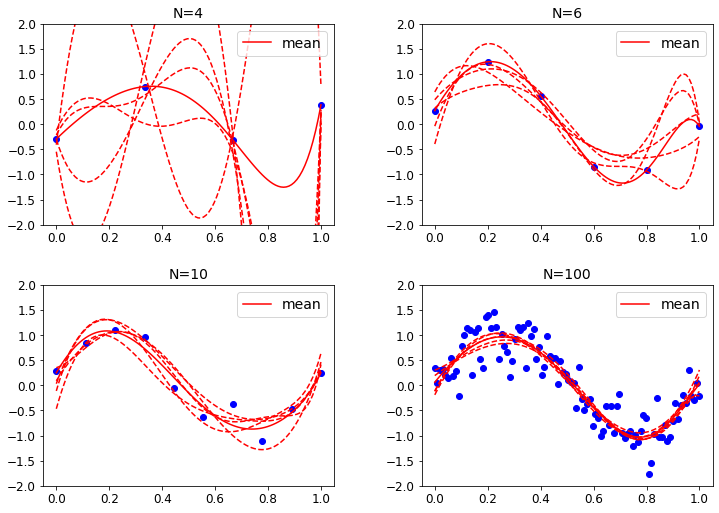

In [8]:
fig = plt.figure(figsize=(12, 8.5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, (xs, ts) in enumerate(trainset):
  subplot = fig.add_subplot(2, 2, i+1)
  show_samples(subplot, xs, ts, 9)